In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [1]:
im_width=128
im_height=128

In [2]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pragunieaditya","key":"641d5093ac1bc7daecec0798cc26d537"}'}

In [3]:
import os
os.rename("kaggle (1).json", "kaggle.json")

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0


In [6]:
!unzip lgg-mri-segmentation.zip -d lgg-mri-segmentation

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1

In [7]:
from glob import glob
import os

mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*.tif')

image_filenames_train = []

for mask in mask_files:
    image_file = mask.replace('_mask', '')
    image_filenames_train.append(image_file)


print("Found image-mask pairs:", len(image_filenames_train))
print("Example image paths:")
print(image_filenames_train[:10])


Found image-mask pairs: 3929
Example image paths:
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_45.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_25.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_39.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_70.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_10.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_66.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_51.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46.tif']


Plotting images and masks

In [8]:
import matplotlib.pyplot as plt
import cv2

plt.style.use("ggplot")

def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))

    for i in range(rows * columns):
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(image)
        ax.imshow(mask, cmap='Reds', alpha=0.4)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

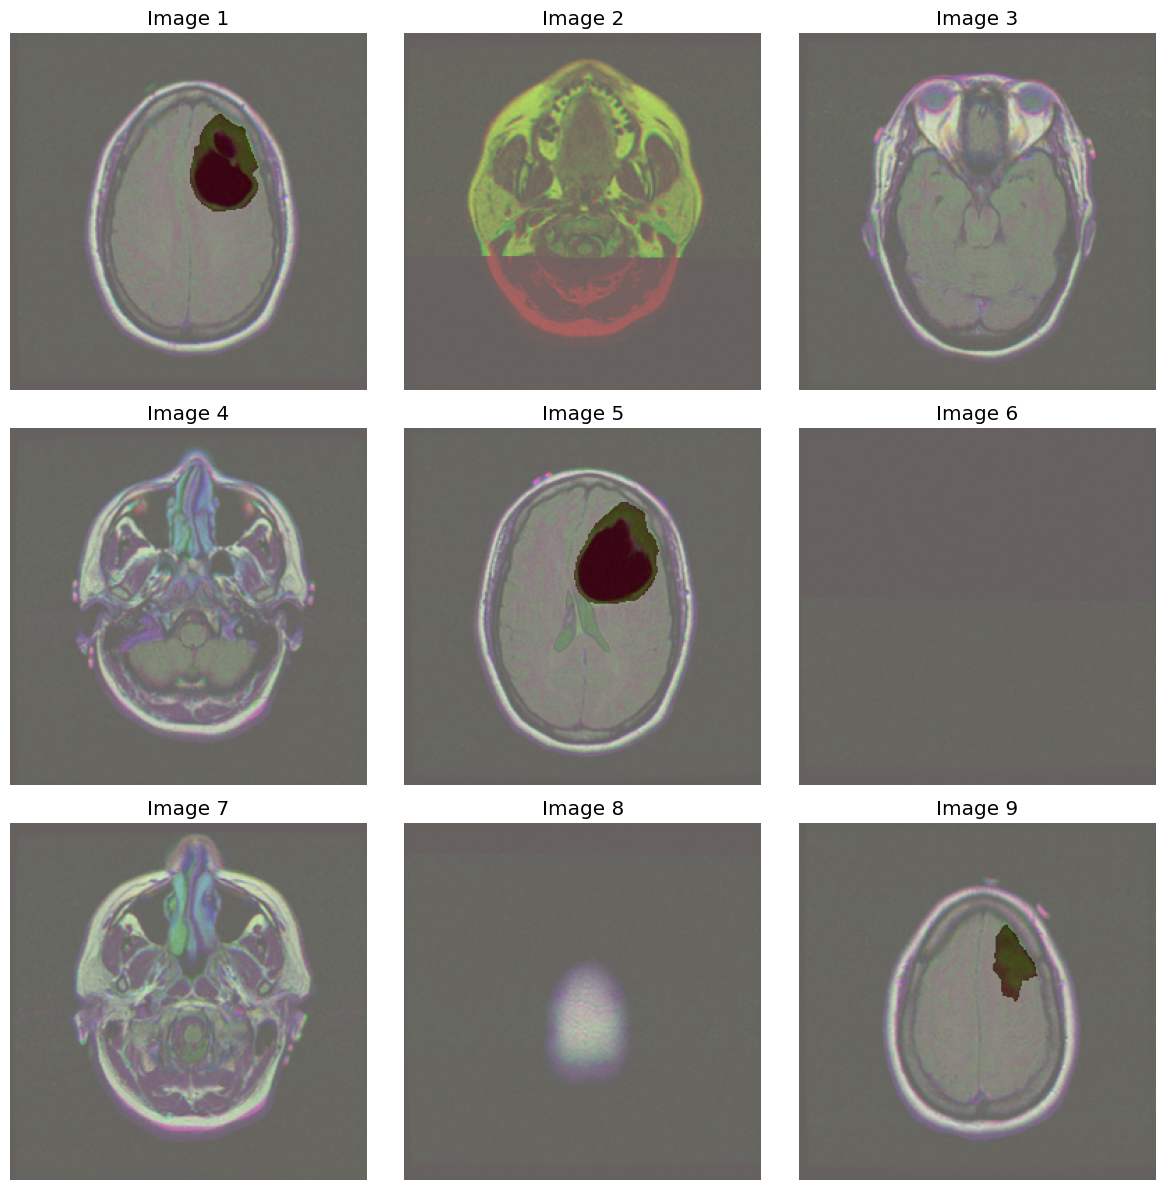

In [9]:
plot_from_img_path(3, 3, image_filenames_train, mask_files)

CREATING DATA FRAME FROM FRAME AND SPLIT DATA ON TRAIN SET,VALIDATION SET AND TEST SET

In [12]:
df=pd.DataFrame(data={'image_filenames_train':image_filenames_train,'mask':mask_files})

df_train,df_test=train_test_split(df,test_size=0.1)

df_train,df_val=train_test_split(df_train,test_size=0.2)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [13]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):

            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

DATA GENERATOR,DATA AUGMENTATION AND ADJUST DATA

In [14]:
def normalise_and_diagnose(img,mask):
    img=img/255
    mask=mask/255
    mask[mask>0.5]=1
    mask[mask<=0.5]=0
    return (img,mask)

In [15]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)


    for (img, mask) in train_gen:
        img, mask = normalise_and_diagnose(img, mask)
        yield (img, mask)

UNET ARCHITECTURE

In [32]:
from tensorflow.keras import backend as K
import tensorflow as tf


def print_tensor_info(tensor, name):
    """Print tensor information for debugging"""
    try:
        print(f"{name} shape: {K.int_shape(tensor)}, dtype: {K.dtype(tensor)}")
    except:
        print(f"Could not print info for {name}")


def dice_coefficients(y_true, y_pred, smooth=100):
    """
    Calculate Dice coefficient between true and predicted masks

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice coefficient (higher is better, max value is 1)
    """

    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    """
    Calculate Dice coefficient loss

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask
        smooth: Smoothing factor

    Returns:
        Dice loss (lower is better, min value is -1)
    """
    return -dice_coefficients(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    """
    Calculate IoU (Intersection over Union)

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask
        smooth: Smoothing factor

    Returns:
        IoU score (higher is better, max value is 1)
    """

    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    sum_ = K.sum(y_true_f) + K.sum(y_pred_f)

    return (intersection + smooth) / (sum_ - intersection + smooth)

def jaccard_distance(y_true, y_pred):
    """
    Calculate Jaccard distance (1 - IoU)

    Args:
        y_true: Ground truth mask
        y_pred: Predicted mask

    Returns:
        Jaccard distance (lower is better, min value is 0)
    """
    return 1.0 - iou(y_true, y_pred)

In [17]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
)

u6=u6+c4
u7=u7+c3
u8=u8+c2
u9=u9+c1

In [18]:

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)


    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    bn1 = BatchNormalization()(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)


    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)


    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)


    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)


    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation('relu')(bn5)


    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), bn4], axis=3)
    conv6 = Conv2D(512, 3, padding='same')(up6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    bn6 = BatchNormalization()(conv6)
    bn6 = Activation('relu')(bn6)


    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), bn3], axis=3)
    conv7 = Conv2D(256, 3, padding='same')(up7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    bn7 = BatchNormalization()(conv7)
    bn7 = Activation('relu')(bn7)


    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), bn2], axis=3)
    conv8 = Conv2D(128, 3, padding='same')(up8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    bn8 = BatchNormalization()(conv8)
    bn8 = Activation('relu')(bn8)


    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), bn1], axis=3)
    conv9 = Conv2D(64, 3, padding='same')(up9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    bn9 = BatchNormalization()(conv9)
    bn9 = Activation('relu')(bn9)


    outputs = Conv2D(1, 1, activation='sigmoid')(bn9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [21]:
EPOCHS=100
BATCH_SIZE=32
learning_rate=5e-4
smooth=100

In [22]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_59']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.8537 - dice_coefficients: 0.0985 - iou: 0.0534 - loss: -0.0985Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01974, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 524ms/step - binary_accuracy: 0.8546 - dice_coefficients: 0.0990 - iou: 0.0537 - loss: -0.0990 - val_binary_accuracy: 0.9906 - val_dice_coefficients: 0.0197 - val_iou: 0.0107 - val_loss: -0.0197
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - binary_accuracy: 0.9867 - dice_coefficients: 0.3130 - iou: 0.1918 - loss: -0.3137
Epoch 2: val_loss improved from -0.01974 to -0.04963, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 847ms/step - binary_accuracy: 0.9867 - dice_coefficients: 0.3136 - iou: 0.1923 - loss: -0.3144 - val_binary_accuracy: 0.6567 - val_dice_coefficients: 0.0496 - val_iou: 0.0258 - val_loss: -0.0496
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - 

In [23]:
import pprint
pprint.pprint(history.history)

{'binary_accuracy': [0.9380748271942139,
                     0.989456295967102,
                     0.9929602742195129,
                     0.993423581123352,
                     0.994032621383667,
                     0.9941167831420898,
                     0.9935440421104431,
                     0.9945212602615356,
                     0.994907796382904,
                     0.9952039122581482,
                     0.9949814081192017,
                     0.9951351881027222,
                     0.9953070282936096,
                     0.9956141710281372,
                     0.995658814907074,
                     0.9958434700965881,
                     0.9959887862205505,
                     0.9961553812026978,
                     0.9959805011749268,
                     0.9962283968925476,
                     0.9960415363311768,
                     0.9963462948799133,
                     0.9962545037269592,
                     0.9964187741279602,
                     

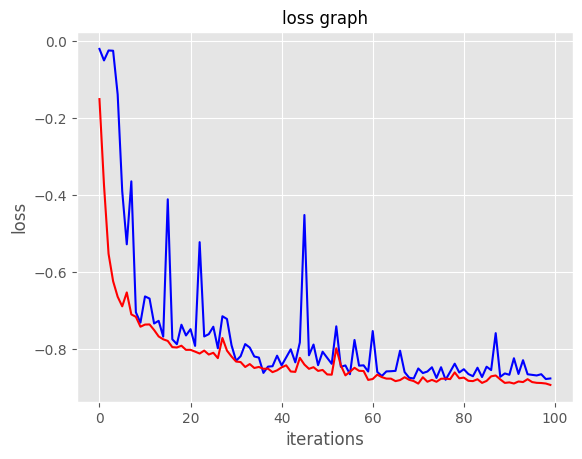

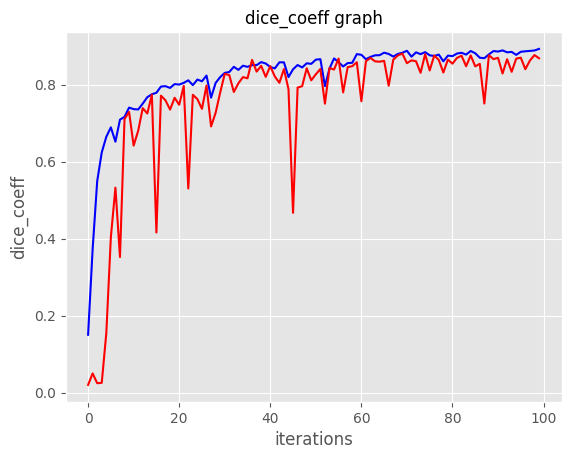

In [27]:
history_post_training=history.history
list_train_dice_coeff=history_post_training['dice_coefficients']
list_test_dice_coeff=history_post_training['val_dice_coefficients']

train_jaccard_list=history_post_training['iou']
test_jaccard_list=history_post_training['val_iou']

train_loss_list=history_post_training['loss']
test_loss_list=history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list,'b-')
plt.plot(train_loss_list,'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph',fontsize=12)

plt.figure(2)
plt.plot(list_train_dice_coeff,'b-')
plt.plot(list_test_dice_coeff,'r-')

plt.xlabel('iterations')
plt.ylabel('dice_coeff')
plt.title('dice_coeff graph',fontsize=12)
plt.show()





In [33]:
model = load_model('unet.keras', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients':dice_coefficients } )

In [34]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) // BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - binary_accuracy: 0.9971 - dice_coefficients: 0.8753 - iou: 0.7821 - loss: -0.8753
Test Loss  -0.8686228394508362
Test IoU  0.9971272349357605
Test Dice Coefficient  0.7717265486717224


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


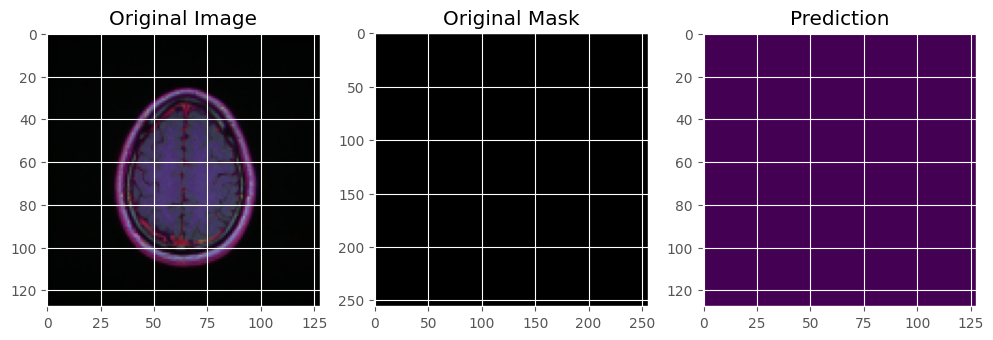

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


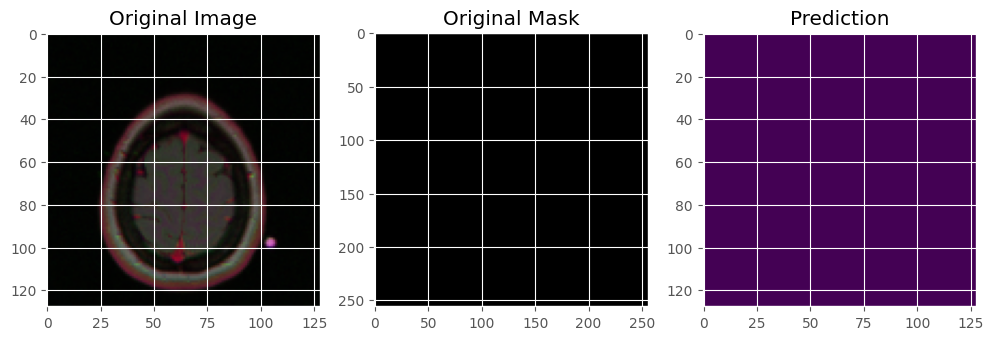

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


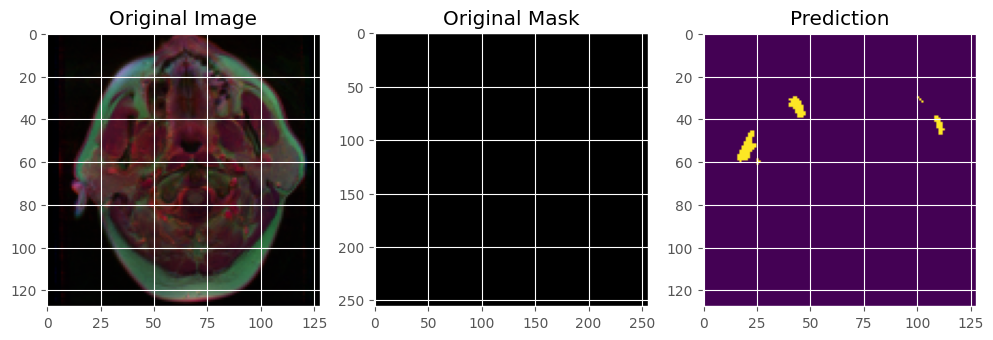

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


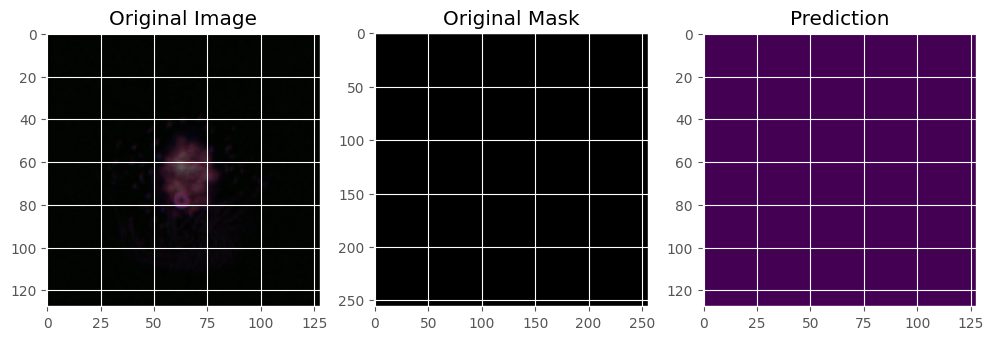

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


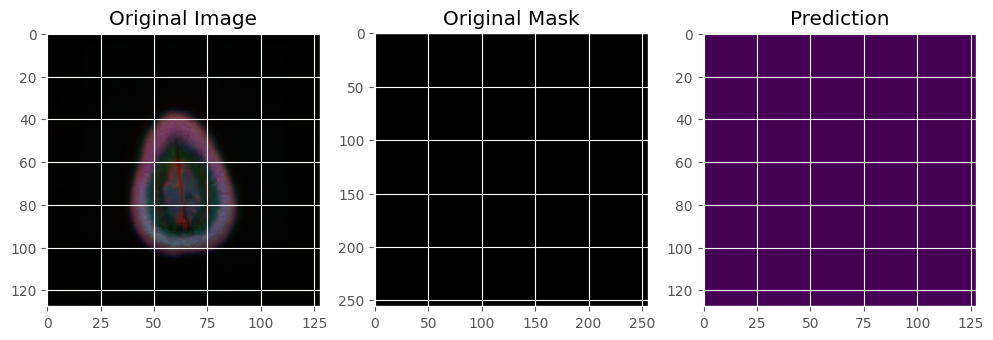

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


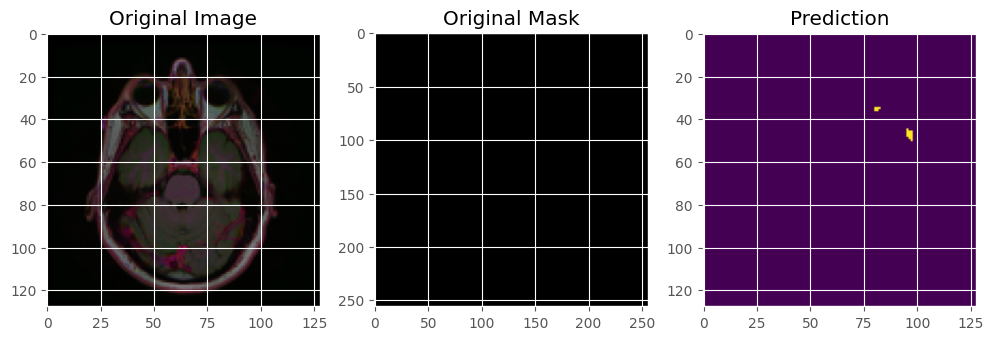

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


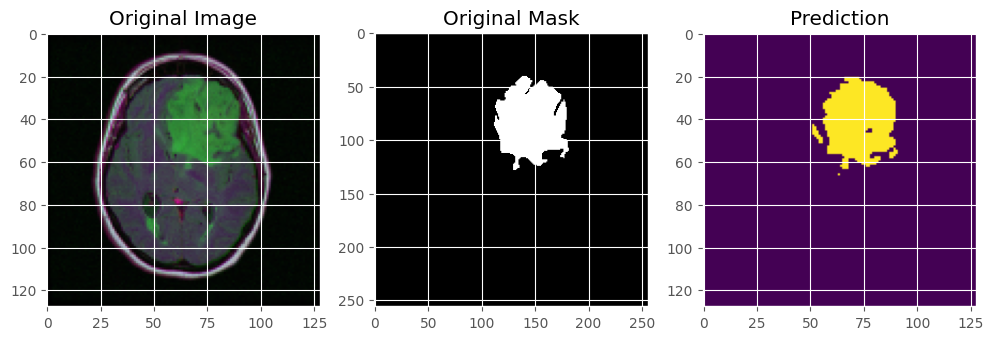

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


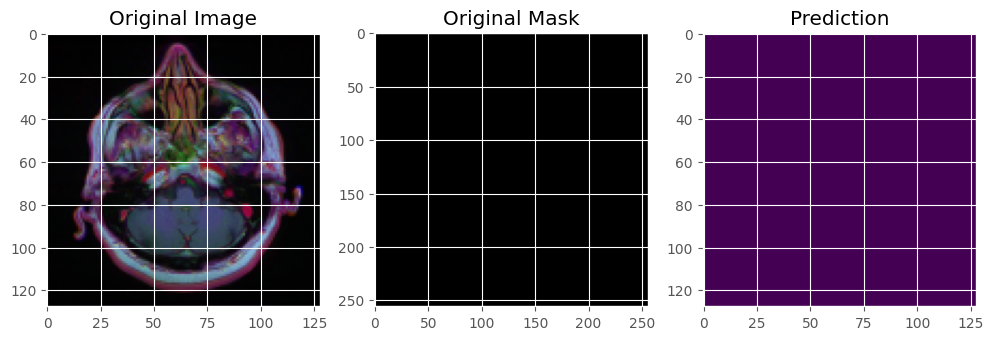

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


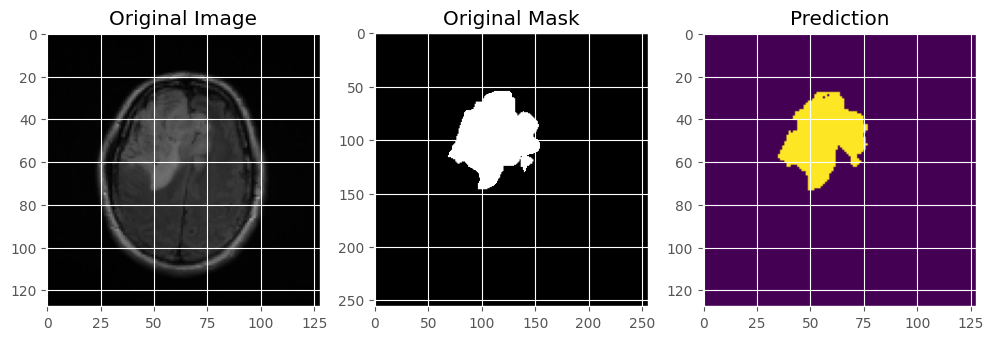

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


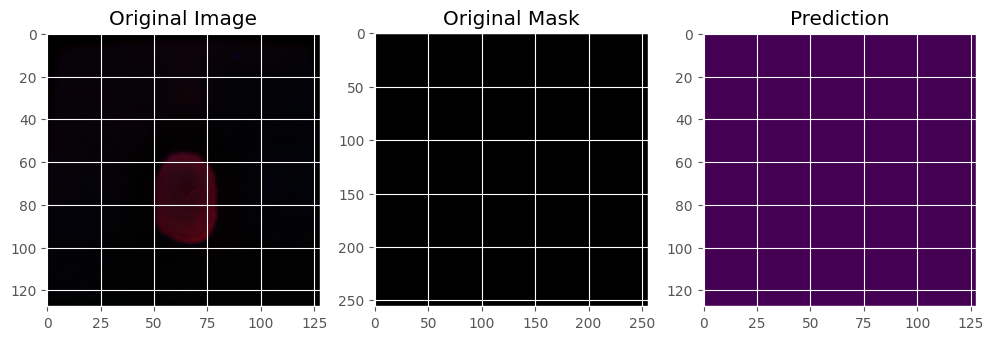

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


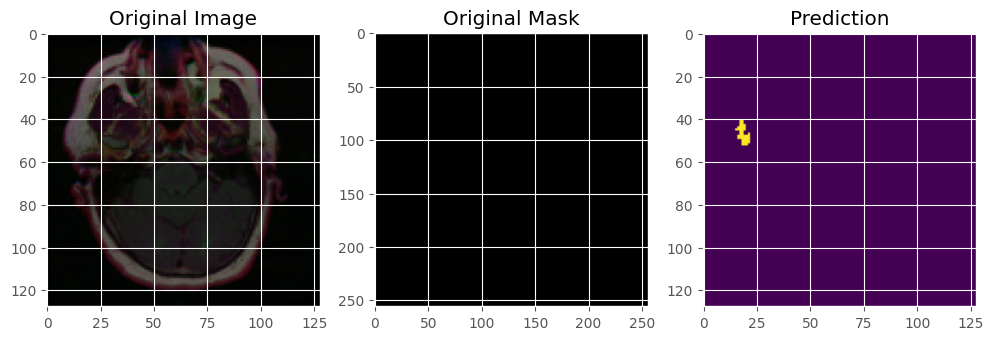

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


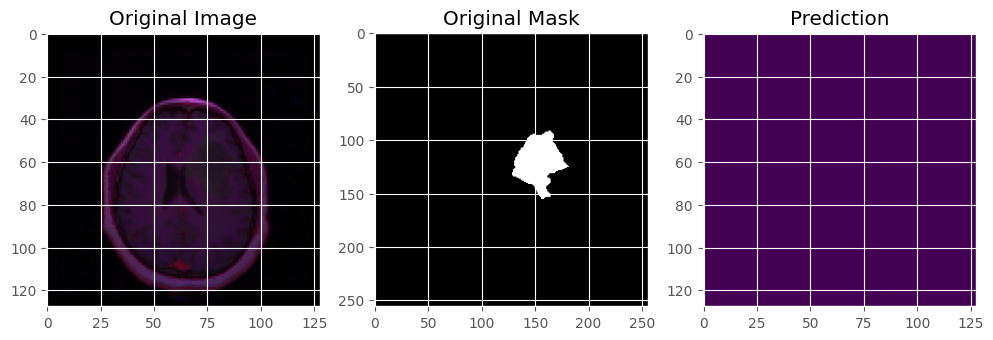

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


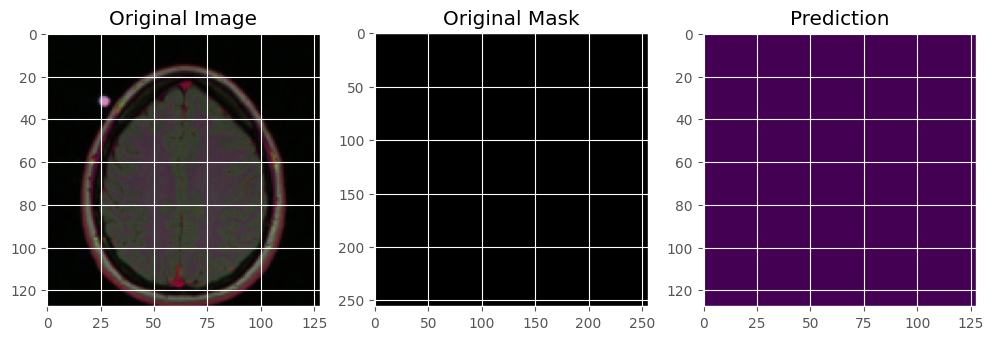

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


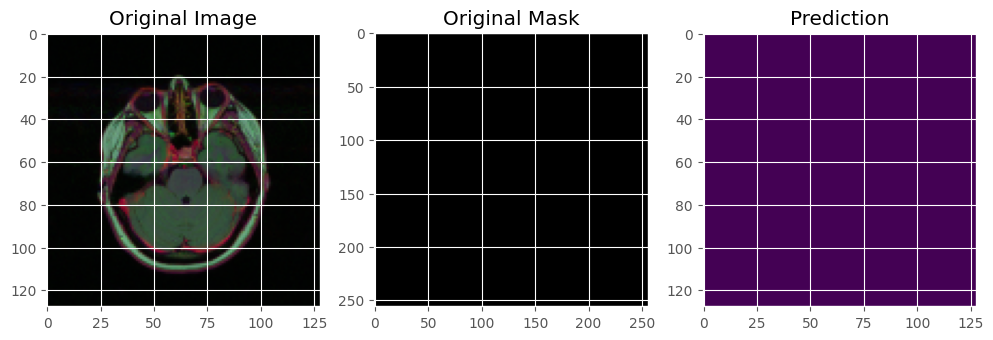

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


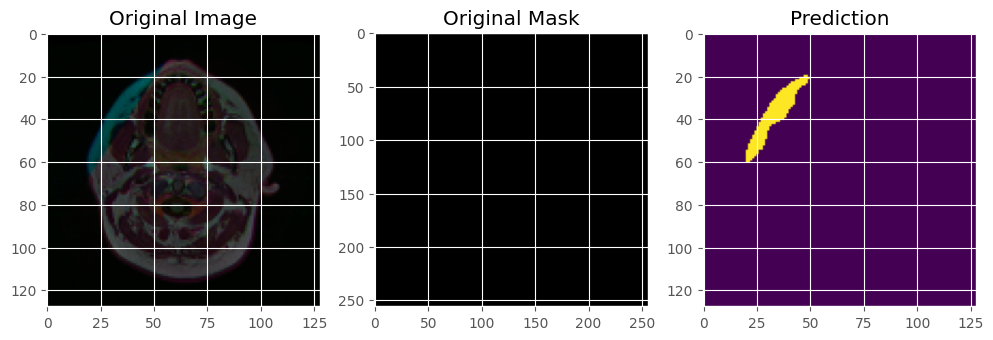

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


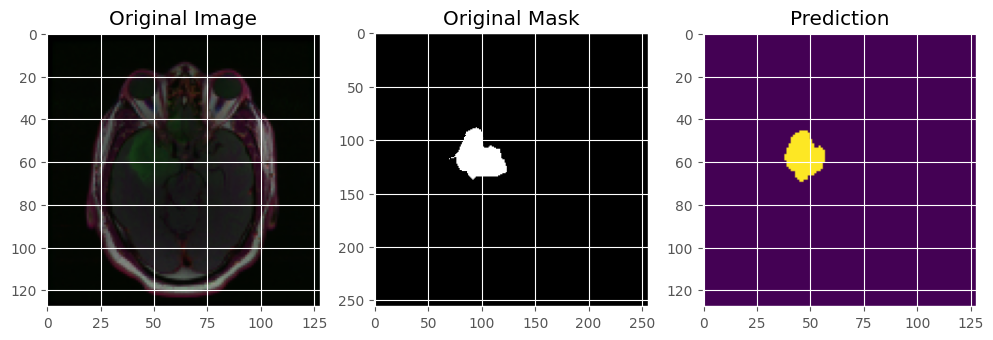

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


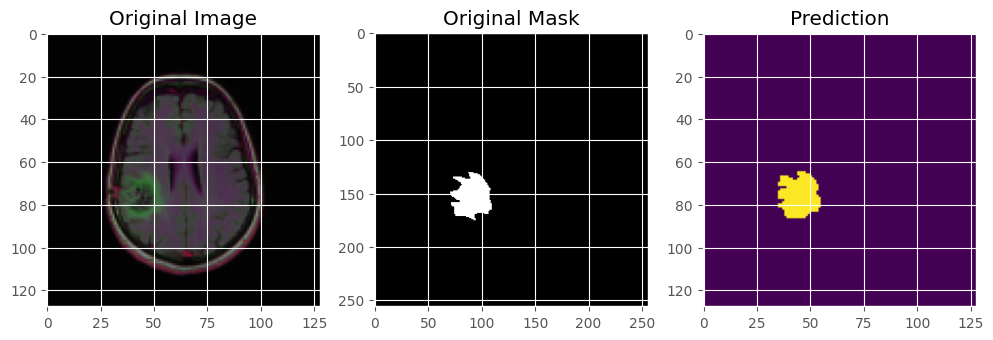

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


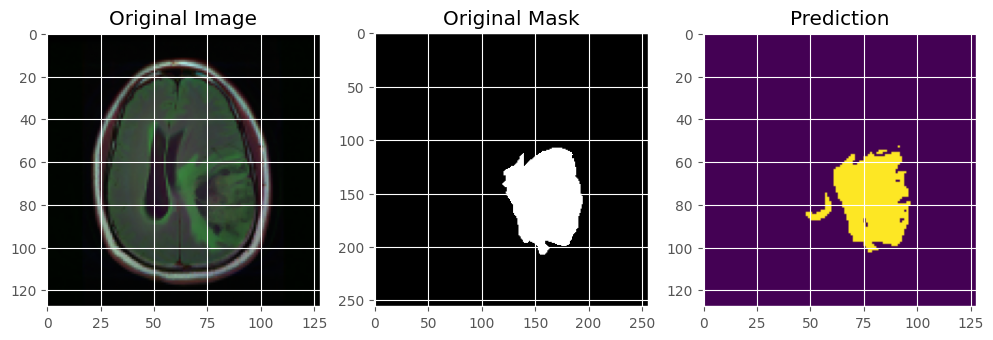

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


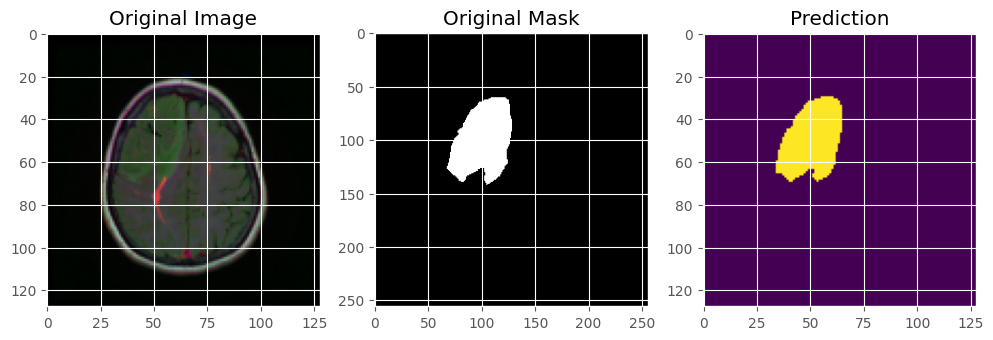

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


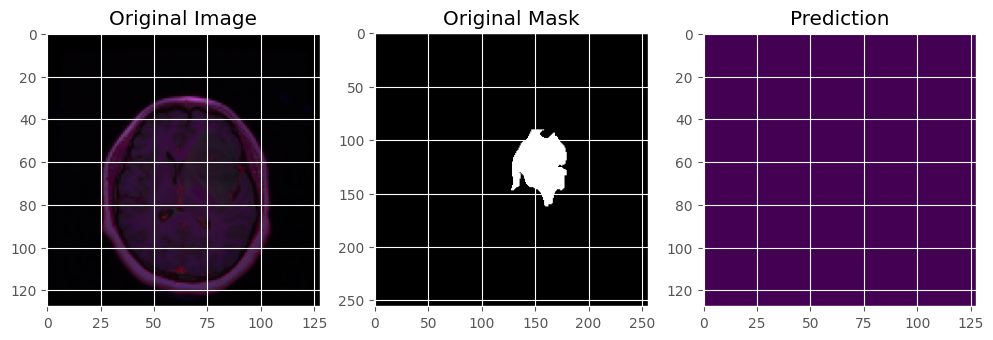

In [38]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255

    img = img[np.newaxis, :, :, : ]


    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()